In [8]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [9]:
inputs_labels = {'t' : 'Time',
                 'T' : 'Temperature'}

#create list of data for high and low.
dat = [('t',30,35,40),
        ('T',150,155,160)]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
t,30,35,40,Time
T,150,155,160,Temperature


In [22]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
t,30,35,40,Time,-1.0,0.0,1.0
T,150,155,160,Temperature,-1.0,0.0,1.0


In [23]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0))
encoded_inputs

[(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

In [25]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['t','T']
results

,t,T
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0


In [26]:
def parse_values(x):
    if x < 2:
       return x * 10
    elif x < 4:
       return x ** 2
    else:
       return x + 10

real_experiment = results
var_labels = []
for var in ['t','T']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)



print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Time,Temperature
0,30,150
1,40,150
2,30,160
3,40,160
4,35,155
5,35,155
6,35,155
7,35,155
8,35,155


In [27]:
y= [39.3, 40.9, 40.0, 41.5, 40.3, 40.5, 40.7, 40.2, 40.6]
results['y']= y
results

,t,T,Time,Temperature,y
0,-1,-1,30,150,39.3
1,1,-1,40,150,40.9
2,-1,1,30,160,40.0
3,1,1,40,160,41.5
4,0,0,35,155,40.3
5,0,0,35,155,40.5
6,0,0,35,155,40.7
7,0,0,35,155,40.2
8,0,0,35,155,40.6


In [28]:
# Data , 4 corners and 5 center points:

df = pd.DataFrame(results,columns=['t','T','y'])
#inputs_df = inputs_df.set_index(['index'])

#print dataframe
df

,t,T,y
0,-1,-1,39.3
1,1,-1,40.9
2,-1,1,40.0
3,1,1,41.5
4,0,0,40.3
5,0,0,40.5
6,0,0,40.7
7,0,0,40.2
8,0,0,40.6


In [29]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['t','T']
print('ybar is', results['y'].mean())
main_effects = {}

print('main effects')
for key in labels:
        average_effects = results.groupby(key)['y'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

ybar is 40.44444444444444
main effects
{'t': np.float64(1.5500000000000043), 'T': np.float64(0.6500000000000057)}


In [30]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = results.groupby([key[0],key[1]])['y'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('t', 'T'): np.float64(-0.05000000000000071)}

In [31]:
y1 = results['y']
xlabs=['t','T']
x = results[xlabs]


res1 = smf.ols(formula='y ~ t + T + t:T', data=results).fit()

res1.summary()

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     26.97
Date:                Mon, 07 Oct 2024   Prob (F-statistic):            0.00163
Time:                        12:09:39   Log-Likelihood:                 4.9676
No. Observations:                   9   AIC:                            -1.935
Df Residuals:                       5   BIC:                            -1.146
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.4444      0.062    649.069      0.000      40.284      40.605
t              0.7750      0.093      8.292      0.000       0.535       1.015
T              0.3250      0.093      3.477      0.018       0.085       0.565
t:T           -0.0250      0.093     -0.267      0.800      -0.265       0.215
==============================================================================
Omnibus:                        0.275   Durbin-Watson:                   2.894
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.078
Skew:                           0.122   Prob(JB):                        0.962
Kurtosis:                       2.614   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
#est1 = sm.OLS(y1,x).fit()
res1 = smf.ols(formula='y ~ t + T', data=results).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     47.82
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           0.000206
Time:                        12:09:45   Log-Likelihood:                 4.9036
No. Observations:                   9   AIC:                            -3.807
Df Residuals:                       6   BIC:                            -3.216
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.4444      0.057    705.987      0.0

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [33]:
Origin = [0,0]
delta= [1.0,0.42]
y=[41.0,42.9,47.1,49.7,53.8,59.9,65.0,70.4,77.6,80.3,76.2,75.1]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['t', 'T'])
ypred=res1.predict(March)

March['y']=y
March['ypred']=ypred

March

,t,T,y,ypred
0,1.0,0.42,41.0,41.355944
1,2.0,0.84,42.9,42.267444
2,3.0,1.26,47.1,43.178944
3,4.0,1.68,49.7,44.090444
4,5.0,2.10,53.8,45.001944
5,6.0,2.52,59.9,45.913444
6,7.0,2.94,65.0,46.824944
7,8.0,3.36,70.4,47.736444
8,9.0,3.78,77.6,48.647944
9,10.0,4.20,80.3,49.559444


Text(0, 0.5, 'Yield')

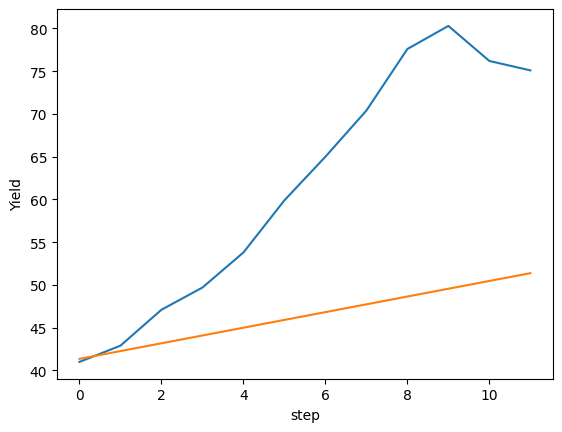

In [34]:
ax=March['y'].plot()
ax=March['ypred'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Yield")